# Assignment 1 - Naive Bayes

## a) Data Preparation

Let's first import all the libraries we need.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Open the iris database.


In [2]:
# Open Iris data
iris = pd.read_csv("iris.tmls")
iris.head()

,sepal length,sepal width,petal length,petal width,class
0,r,r,r,r,n
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa


We are going to remove the first row (format row), and shuffle the data.

In [3]:
data = iris.drop(0) # Remove first row
data = data.sample(frac = 1) # Suffle rows of the data set
data.head()

,sepal length,sepal width,petal length,petal width,class
131,7.4,2.8,6.1,1.9,Iris-virginica
4,4.6,3.1,1.5,0.2,Iris-setosa
20,5.1,3.8,1.5,0.3,Iris-setosa
61,5.0,2.0,3.5,1.0,Iris-versicolor
109,6.7,2.5,5.8,1.8,Iris-virginica


Split iris into X (features) and y (labels). (We create a function to help us later with the ROC curve)

In [4]:
def split_iris_to_X_and_y(data, label_to_remove = None):
    new_data = data.sample(frac = 1) # Suffle rows of the data set
    if (not(label_to_remove is None)):
        new_data = new_data[new_data["class"] != label_to_remove] # Drop class
    X = new_data.iloc[:, 0:-1].apply(pd.to_numeric, errors='coerce')
    y = new_data.iloc[:, -1]
    return X, y

In [5]:
X, y = split_iris_to_X_and_y(data)
print(X.head())
print(y.head())

    sepal length  sepal width  petal length  petal width
8            5.0          3.4           1.5          0.2
30           4.7          3.2           1.6          0.2
26           5.0          3.0           1.6          0.2
87           6.7          3.1           4.7          1.5
36           5.0          3.2           1.2          0.2
8         Iris-setosa
30        Iris-setosa
26        Iris-setosa
87    Iris-versicolor
36        Iris-setosa
Name: class, dtype: object


## b) Creation Model

We gonna use the **Gaussian Naive Bayes** classifier model because the features are **continuous**.

In [6]:
class MyGaussianNaiveBayes:
    
    # The fit method trains the model on a given dataset
    # by computing the mean and variance of each feature for each class
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.learned_distribs = {}
        self.prior_probs = {}

        for label in self.classes:

            # Get all X grouped by the current label
            X_class = X[label == y]

            # Calculate the prior probability for each class
            self.prior_probs[label] = X_class.shape[0] / len(self.classes)

            # Axis=0 means to calculate for each column (for each feature)
            means = np.mean(X_class, axis=0)
            variances = np.var(X_class, axis=0)

            # Note: I called means and variances (plurial) because of the shape (4,1) -> due to the multiple features

            # Store the learning distrib
            self.learned_distribs[label]= (means, variances)

        return 0

    def gaussian_distribution(self, x, means, variances):
        # Calc the probabilities for x, a simple data row
        num = (x - means) ** 2
        norm = 1 / np.sqrt(2 * np.pi * variances)
        arr = norm * np.exp(-0.5 * (num / variances))
        return np.prod(arr)



    def predict(self, X):
        predictions = []
        probabilities = []

        for x in X: # Iterate on each row

            different_probabilities = {}
            total_prob = 0

            for label in self.classes: # Calc prob for each class
                
                means, variances = self.learned_distribs[label]

                prob = self.gaussian_distribution(x, means, variances)
                posterior_prob = prob * self.prior_probs[label]

                different_probabilities[label] = posterior_prob
                total_prob += posterior_prob

            # Get the class with the highest probability by finding the maximum value in each np.array in probabilities
            # and using the max() function to get the class associated with it.
            prediction = max(different_probabilities, key=lambda x: different_probabilities[x])
            predictions.append(prediction)

            tmp = []
            # Put probabilities in the following format
            # [
            #   0.999999, 0.000001
            #   0.26, 0.74
            # ]
            for label in self.classes:
                tmp.append(different_probabilities[label] / total_prob)
            probabilities.append(np.array(tmp))

        return np.array(predictions), np.array(probabilities)


## c) Apply Model

Before setting up the 10-fold cross-validation and the ROC curve, we define a function to calculate the general accuracy.

In [7]:
# Function to calculate the accuracy of the model
def accuracy_score(y_true, y_pred):
    # Number of correct predictions
    correct = np.sum(y_true == y_pred)

    # Total number of predictions
    total = len(y_true)

    # Accuracy
    accuracy = correct / total
    return accuracy

As we will not have answers equal to 0 or 1, we need to convert the categories into 0 and 1. Here is the function that can convert an array of categories into binary.

In [8]:
def convert_categories_into_binary(arr_str):
    unique = np.unique(arr_str)
    dic = { # Useless but ideal to understand
        unique[0]: 0,
        unique[1]: 1
    }
    arr_str[arr_str == unique[0]] = 0
    arr_str[arr_str == unique[1]] = 1
    
    return np.asfarray(arr_str, int)


And here, we apply the previous function to do the ROC curve algorithm.

In [9]:
def plot_roc(fpr, tpr, label):
    # Plot the TPR and FPR values to generate the ROC curve
    title = 'ROC curve for Gaussian Naive Bayes Classifier (' + label + ')'
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], 'k--' )
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [10]:
def calculate_fpr_tpr(y_pred, y_true, threshold):
    predictions = (y_pred >= threshold).astype(int)
        
    tp = np.sum(np.logical_and(predictions == 1, y_true == 1))
    fn = np.sum(np.logical_and(predictions == 0, y_true == 1))
    fp = np.sum(np.logical_and(predictions == 1, y_true == 0))
    tn = np.sum(np.logical_and(predictions == 0, y_true == 0))
    tpr_rate = tp / (tp + fn)
    fpr_rate = fp / (fp + tn)

    return fpr_rate, tpr_rate 

def roc(probabilities, y_test, label=""):
    y_bin = convert_categories_into_binary(np.copy(y_test))

    thresholds = np.linspace(0,1, num=11)
    
    fpr = []
    tpr = []
    # Iterate over the thresholds
    for threshold in thresholds:
        fpr_tmp, tpr_tmp = calculate_fpr_tpr(probabilities, y_bin, threshold)
        fpr.append(fpr_tmp)
        tpr.append(tpr_tmp)
    fpr.append(0)
    tpr.append(0)
    fpr = np.array(fpr)
    tpr = np.array(tpr)

    plot_roc(fpr, tpr, label)

Finally, we can write it !

General accuracy for Iris-virginica vs Iris-setosa: 1.0


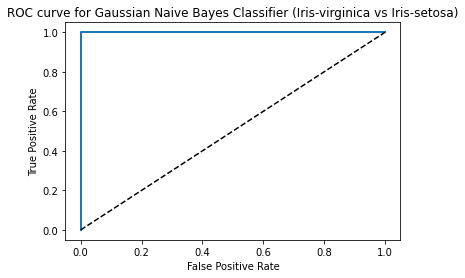

General accuracy for Iris-versicolor vs Iris-setosa: 1.0


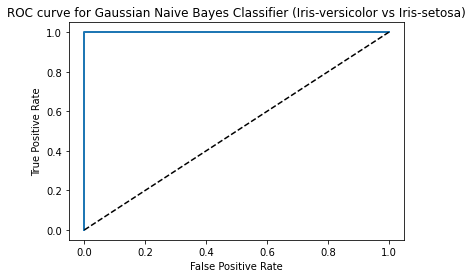

General accuracy for Iris-versicolor vs Iris-virginica: 0.9733333333333332


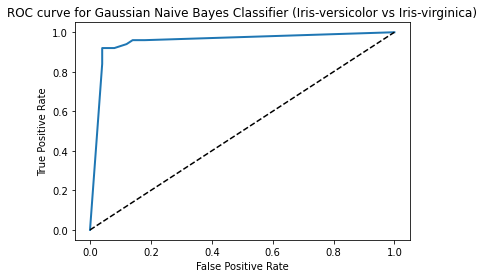

In [13]:
# Create empty lists to store the accuracy scores
accuracies = []
categories = ["Iris-versicolor", "Iris-virginica", "Iris-setosa"]
for category in categories:

    # We drop category
    X, y = split_iris_to_X_and_y(data, category)

    # We setting up the variables needed for the 10-fold cross-validation and for the ROC curve

    # Number of folds
    n_folds = 10
    # Calculate the size of each fold
    fold_size = len(X) // n_folds
    # Store the predictions
    predictions = []

    # Store all the probabilities and y_test for ROC
    probabilities = []
    labels = []

    # 10-fold cross-validation
    for i in range(n_folds):

        # Get the training data
        X_train = np.concatenate([X[:i * fold_size], X[(i + 1) * fold_size:]])
        y_train = np.concatenate([y[:i * fold_size], y[(i + 1) * fold_size:]])

        # Get the testing data
        X_test = X[i * fold_size : (i + 1) * fold_size].to_numpy()
        y_test = y[i * fold_size : (i + 1) * fold_size].to_numpy()


        model = MyGaussianNaiveBayes()

        # Train the model
        model.fit(X_train, y_train)

        # Predict the class of the testing set
        y_pred, y_prob = model.predict(X_test)
        predictions.append(y_pred)

        # Store for ROC
        probabilities.append(y_prob)
        labels.append(y_test)

        # Calculate the accuracy of your model
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        

    categories = ["Iris-versicolor", "Iris-virginica", "Iris-setosa"]
    categories.remove(category)
    label = " vs ".join(categories)

    # Print out the mean accuracy
    print("General accuracy for " + label + ":", np.mean(accuracies))

    # Plot ROC curves
    roc(np.concatenate(probabilities)[:, 1], np.concatenate(labels), label=label)